<a href="https://colab.research.google.com/github/kuds/rl-fetch/blob/main/Fetch/Reach/%5BFetch%20Reach%5D%20Deep%20Deterministic%20Policy%20Gradient%20(DDPG).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mujoco

# Set up GPU rendering.
from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

In [2]:
!pip install stable-baselines3

In [3]:
!pip install git+https://github.com/Farama-Foundation/Gymnasium-Robotics.git

  Cloning https://github.com/Farama-Foundation/Gymnasium-Robotics.git to /tmp/pip-req-build-3d7crdzn
  Running command git clone --filter=blob:none --quiet https://github.com/Farama-Foundation/Gymnasium-Robotics.git /tmp/pip-req-build-3d7crdzn
  Resolved https://github.com/Farama-Foundation/Gymnasium-Robotics.git to commit 2d1c1f95ecd9179849248a5bced308d43775e732
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
import torch
import datetime
import platform
from importlib.metadata import version
import gymnasium
import os
import numpy
import matplotlib
import matplotlib.pyplot
import gymnasium_robotics
import google.colab
from stable_baselines3 import DDPG
from stable_baselines3.her import HerReplayBuffer
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import VecVideoRecorder
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.her.goal_selection_strategy import GoalSelectionStrategy

In [5]:
print(f"Python Version: {platform.python_version()}")
print(f"Torch Version: {version('torch')}")
print(f"Is Cuda Available: {torch.cuda.is_available()}")
print(f"Cuda Version: {torch.version.cuda}")
print(f"Mujoco Version: {version('mujoco')}")
print(f"Gymnasium Version: {version('gymnasium')}")
print(f"Gymnasium Robotics Version: {version('gymnasium_robotics')}")
print(f"Numpy Version: {version('numpy')}")
print(f"Stable Baselines3 Version: {version('stable_baselines3')}")

Python Version: 3.10.12
Torch Version: 2.5.1+cu121
Is Cuda Available: True
Cuda Version: 12.1
Mujoco Version: 3.2.6
Gymnasium Version: 1.0.0
Gymnasium Robotics Version: 1.3.1
Numpy Version: 1.26.4
Stable Baselines3 Version: 2.4.1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# Register Gymansium Robotics Environment
gymnasium.register_envs(gymnasium_robotics)

In [7]:
rl_type = "DDPG"
env_str = "FetchReachDense-v4"
name_prefix = f"fetch_reach_{rl_type}".lower()
log_dir = "./logs/{}".format(env_str)

In [8]:
env = gymnasium.make(env_str)
print("Observation Space Size: ", env.observation_space)
print('Actions Space: ', env.action_space)
env.close()

Observation Space Size:  Dict('achieved_goal': Box(-inf, inf, (3,), float64), 'desired_goal': Box(-inf, inf, (3,), float64), 'observation': Box(-inf, inf, (10,), float64))
Actions Space:  Box(-1.0, 1.0, (4,), float32)


In [9]:
# Create Training Fetch Push environment
env = make_vec_env(env_str, n_envs=1)

# Create Evaluation Fetch Push environment
env_val = make_vec_env(env_str, n_envs=1)

# Create Evaluation Callback
# eval_freq - can cause learning instability if set to low
eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             eval_freq=50_000,
                             render=False,
                             deterministic=True,
                             n_eval_episodes=20)

# Instantiate the agent
model = DDPG("MultiInputPolicy",
             env,
             learning_rate=1e-3,  # You can adjust this
             buffer_size=int(1e6),
             replay_buffer_class=HerReplayBuffer,
             replay_buffer_kwargs=dict(
                 n_sampled_goal=4,
                 goal_selection_strategy=GoalSelectionStrategy.FUTURE
             ),
             #action_noise=action_noise,  # Add some action noise for exploration
             gamma=0.95,
             tau=0.05,
             batch_size=256,
             verbose=0)

# Train the agent with the callback
model.learn(total_timesteps=500_000,
            callback=eval_callback,
            progress_bar=True)

# Save the model
model.save(os.path.join(log_dir, "final_model"))

mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print(f"Final Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Close the environment
env.close()
env_val.close()

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 499,996/500,000  [ 2:10:28 < 0:00:01 , 64 it/s ]

Eval num_timesteps=500000, episode_reward=-0.48 +/- 0.36

Episode length: 50.00 +/- 0.00

Success rate: 100.00%

Final Mean reward: -0.56 +/- 0.39


In [9]:
# Create Evaluation Fetch Push environment
env = make_vec_env(env_str, n_envs=1, seed=0)

# Load the best model
best_model_path = os.path.join(log_dir, "best_model.zip")
best_model = DDPG.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env, n_eval_episodes=20)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model playing Fetch Push
env = VecVideoRecorder(env, "./videos/",
                       video_length=10000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix="best_model_{}".format(name_prefix))

n_sims = 5
obs = env.reset()
for _ in range(10000):
    action, _states = best_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
        n_sims = n_sims - 1
        if n_sims == 0:
            break
        obs = env.reset()

env.close()

Best Model - Mean reward: -0.57 +/- 0.48
Moviepy - Building video /content/videos/best_model_fetch_reach_ddpg-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/videos/best_model_fetch_reach_ddpg-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/best_model_fetch_reach_ddpg-step-0-to-step-10000.mp4


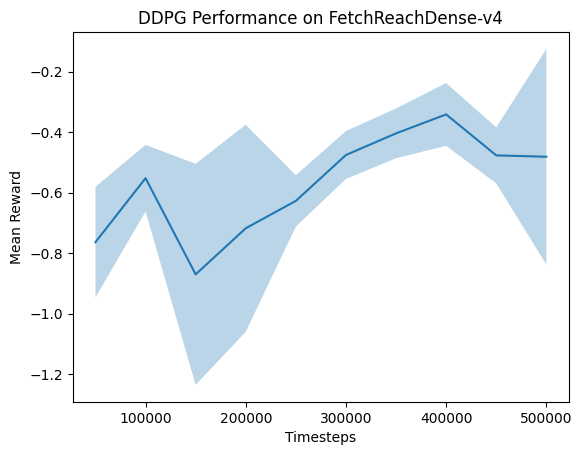

In [10]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title(f"{rl_type} Performance on {env_str}")
matplotlib.pyplot.show()